In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from pyproj import Proj, Transformer
from scipy.interpolate import griddata
import xeofs as xe
from geometry_izzyv1 import grad_sphere
from regression_izzyv1 import linregress_3D
import cartopy.crs as ccrs

crs = ccrs.PlateCarree()
import warnings
import os

warnings.filterwarnings('ignore')
from matplotlib.ticker import MultipleLocator

In [26]:
#open the different datasets (dot + ERA5 remap)
path = '/Users/iw2g24/PycharmProjects/SSH_project/'
print(path)
ds = xr.open_dataset(path + 'Data/dot_all_30bmedian_goco05c_sig3_1.nc')
print(ds)
# ERA5 remap dataset
gridtype = 'remapcon'
ds_era5 = xr.open_dataset(path + 'Data/ERA5_u10v10_Antartica_2000-2023_' + gridtype + '.nc')


/Users/iw2g24/PycharmProjects/SSH_project/
<xarray.Dataset> Size: 109MB
Dimensions:          (longitude: 360, latitude: 64, time: 196, edge_lat: 65,
                      edge_lon: 361)
Coordinates:
  * longitude        (longitude) float64 3kB -179.5 -178.5 ... 178.5 179.5
  * latitude         (latitude) float64 512B -81.75 -81.25 ... -50.75 -50.25
  * time             (time) datetime64[ns] 2kB 2002-07-01 ... 2018-10-01
  * edge_lat         (edge_lat) float64 520B -82.0 -81.5 -81.0 ... -50.5 -50.0
  * edge_lon         (edge_lon) float64 3kB -180.0 -179.0 -178.0 ... 179.0 180.0
Data variables:
    dot              (longitude, latitude, time) float64 36MB ...
    ug               (longitude, latitude, time) float64 36MB ...
    vg               (longitude, latitude, time) float64 36MB ...
    land_mask        (longitude, latitude) float64 184kB ...
    intersat_offset  float64 8B ...
Attributes:
    history:      Created 08/01/2022, 00:5223
    description:  ENVISAT + CryoSat2 altimetry 

In [27]:
path = '/Users/iw2g24/PycharmProjects/SSH_project/mca_shared_izzy/'
ice_vels_ds = xr.open_dataset(path + 'NSIDC-0792_19920317-20171216_V01.0.nc')
print(ice_vels_ds)

<xarray.Dataset> Size: 25GB
Dimensions:            (x: 2916, y: 2916, time: 104)
Coordinates:
  * x                  (x) float64 23kB -2.798e+06 -2.796e+06 ... 2.798e+06
  * y                  (y) float64 23kB 2.798e+06 2.796e+06 ... -2.798e+06
  * time               (time) datetime64[ns] 832B 1992-03-17T03:04:19.2000023...
Data variables: (12/16)
    melt               (time, y, x) float32 4GB ...
    melt_mean          (y, x) float32 34MB ...
    melt_err           (time, y, x) float32 4GB ...
    height_change      (time, y, x) float32 4GB ...
    height_change_err  (y, x) float32 34MB ...
    fac                (time, y, x) float32 4GB ...
    ...                 ...
    smb_err            (time, y, x) float32 4GB ...
    thickness          (time, y, x) float32 4GB ...
    thickness_mean     (y, x) float32 34MB ...
    thickness_err      (y, x) float32 34MB ...
    ID                 (y, x) uint8 9MB ...
    crs                |S1 1B ...
Attributes:
    Conventions:   CF-1.6
    da

In [28]:
path = '/Users/iw2g24/PycharmProjects/SSH_project/mca_shared_izzy/'
print(path)
WSC_eumetsat_ds = xr.open_dataset(path + 'WSC_eumetsat_masked.nc')
WSC_nsidc_ds = xr.open_dataset(path + 'WSC_nsidc_masked.nc')
sidc_eumetsat_ds = xr.open_dataset(path + 'sidc_eumetsat_masked.nc')
sidc_nsidc_ds = xr.open_dataset(path + 'sidc_nsidc_masked.nc')
tau_nsidc_ds = xr.open_dataset(path + 'tau_nsidc_ds.nc')
tau_eumetsat_ds = xr.open_dataset(path + 'tau_eumetsat_ds2.nc')
dot_masked_ds = xr.open_dataset(path + 'dot_masked.nc')
OSC_eumetsat_ds = xr.open_dataset(path+'OSC_eumetsat_ds.nc')
OSC_nsidc_ds = xr.open_dataset(path+'OSC_nsidc_ds.nc')

/Users/iw2g24/PycharmProjects/SSH_project/mca_shared_izzy/


In [29]:
# 1st SVD PCA modes of time series and SAM index (monthly and seas) for SSH, WSC, OCS

In [30]:
path = '/Users/iw2g24/PycharmProjects/SSH_project/mca_shared_izzy/'
ds_monthly_sam = xr.open_dataset('monthly_sam.nc')
ds_seas_sam = xr.open_dataset('seas_sam.nc')

In [31]:
monthly_sam = ds_monthly_sam['SAM']
print(monthly_sam)
monthly_time = ds_monthly_sam['time'].values
print(len(monthly_time))

monthly_sam_start_date = 546
monthly_sam_end_date = 741
print(monthly_sam_start_date)
print(monthly_sam_end_date)

filtered_monthly_sam = monthly_sam[monthly_sam_start_date:monthly_sam_end_date + 1]

# Compute mean and standard deviation
f_monthly_sam_mean = filtered_monthly_sam.mean()
f_monthly_sam_std = filtered_monthly_sam.std()

# Normalize SAM
normalized_monthly_sam = (filtered_monthly_sam - f_monthly_sam_mean) / f_monthly_sam_std
print(normalized_monthly_sam.values)



<xarray.DataArray 'SAM' (time: 828)> Size: 7kB
[828 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 7kB 1957-01-01T12:00:00 ... 2025-12-01T12:...
828
546
741
[-6.98651800e-01  4.07097531e-01 -1.62112776e+00 -3.81429909e+00
 -2.71013937e-01  4.98734216e-01 -6.07015116e-01 -8.88034283e-01
 -3.32105061e-01  1.06077255e+00  3.46006408e-01 -1.82883758e+00
  4.43752205e-01  1.13408190e+00 -8.94143395e-01 -2.16031926e-01
 -3.80977959e-01 -7.10870025e-01  1.27459148e+00 -2.32367568e+00
  1.62733038e-01  4.43752205e-01 -3.80977959e-01  7.43098710e-01
  1.25015503e+00 -2.89341274e-01  7.91971608e-01 -6.49778902e-01
 -1.01021653e+00 -9.12470732e-01  3.64333745e-01  6.82007586e-01
 -3.62650622e-01  1.82441159e+00 -5.64251329e-01 -5.39814880e-01
 -5.94796891e-01  1.61143422e-02 -5.10858934e-02 -3.56541510e-01
  1.13860140e-01 -1.97545628e+00  5.27690162e-02 -1.41952706e+00
  7.24771373e-01 -7.10870025e-01  1.10353634e+00  9.63026753e-01
  6.94225811e-01 -1.90214693e+00 -4

In [32]:
ann_sam = ds_seas_sam['ANN_sam']
print(ann_sam)
ann_time = ds_seas_sam['ANN_time'].values
print(len(ann_time))

ann_sam_start_date = 50
ann_sam_end_date = 61
print(ann_sam_start_date)
print(ann_sam_end_date)

filtered_ann_sam = ann_sam[ann_sam_start_date:ann_sam_end_date + 1]


# Compute mean and standard deviation
f_ann_sam_mean = filtered_ann_sam.mean()
f_ann_sam_std = filtered_ann_sam.std()

# Normalize SAM
normalized_ann_sam = (filtered_ann_sam - f_ann_sam_mean) / f_ann_sam_std
print(normalized_ann_sam.values)


<xarray.DataArray 'ANN_sam' (year: 68)> Size: 544B
[68 values with dtype=float64]
Coordinates:
  * year      (year) int64 544B 1957 1958 1959 1960 1961 ... 2021 2022 2023 2024
    ANN_time  (year) datetime64[ns] 544B ...
    AUT_time  (year) datetime64[ns] 544B ...
    WIN_time  (year) datetime64[ns] 544B ...
    SPR_time  (year) datetime64[ns] 544B ...
    SUM_time  (year) datetime64[ns] 544B ...
68
50
61
[-1.81822576  0.54243628 -1.05197809  1.31642383 -0.61080518  0.41085839
 -0.99005908 -0.20833165  1.97431325  0.07030387  0.07030387  0.29476026]


In [33]:
# Define a function to normalize SAM data for each season
def normalize_seasonal_sam(season_sam, season_time, start_date, end_date):
    filtered_season_sam = season_sam[start_date:end_date + 1]

    # Compute mean and standard deviation
    season_sam_mean = filtered_season_sam.mean()
    season_sam_std = filtered_season_sam.std()

    # Normalize SAM
    normalized_season_sam = (filtered_season_sam - season_sam_mean) / season_sam_std
    return normalized_season_sam

# Define the start and end dates for each season
season_dates = {
    "SPR": (45, 61),  # Spring start and end dates
    "WIN": (45, 61),  # Annual start and end dates
    "SUM": (45, 61),  # Summer start and end dates
    "AUT": (46, 61)   # Autumn start and end dates
}

# Assume ds_seas_sam contains the seasonal SAM data as before
seasons = ["SPR", "WIN", "SUM", "AUT"]

# Store the normalized SAM data for each season
normalized_sams = {}

for season in seasons:
    # Extract seasonal data and time
    season_sam = ds_seas_sam[f'{season}_sam']
    season_time = ds_seas_sam[f'{season}_time'].values
    start_date, end_date = season_dates[season]

    # Normalize the seasonal SAM
    normalized_sams[season] = normalize_seasonal_sam(season_sam, season_time, start_date, end_date)

# Print the normalized SAM values for each season
for season, normalized_sam in normalized_sams.items():
    print(f"Normalized {season} SAM:", normalized_sam.values)


Normalized SPR SAM: [-2.26100444 -0.50639515  0.06080484  0.21453193  0.33645343 -0.92516897
  0.89305154 -0.2837559   1.57157115 -0.95697457 -0.09292226 -1.07889607
 -0.19364002  0.83474126 -0.25725123  0.65981043  1.98504403]
Normalized WIN SAM: [-0.50206446 -0.04216077  0.90153773 -0.63346552 -0.16161627 -1.69661952
  0.56706231 -1.10531476  1.94080062 -1.08142366  1.42714195 -0.96794093
  0.26245077  1.42116917  0.40579738  0.20272302 -0.93807706]
Normalized SUM SAM: [-0.42061471 -0.95193732 -0.42701619 -1.99537812  0.40517585  1.35259449
  0.52040244 -0.7342871  -0.20936596  1.14134574 -0.22216892 -0.31819108
  1.72388017  0.76365858 -1.75852346  0.85327926  0.27714631]
Normalized AUT SAM: [ 1.03432861 -0.15242737  0.54438348  1.0016656  -2.0033312  -1.41539704
 -0.94722725  0.15242737  0.6097095   0.8601259   0.6097095  -0.68592318
  0.67503551  0.90367657  0.57704649 -1.76380247]


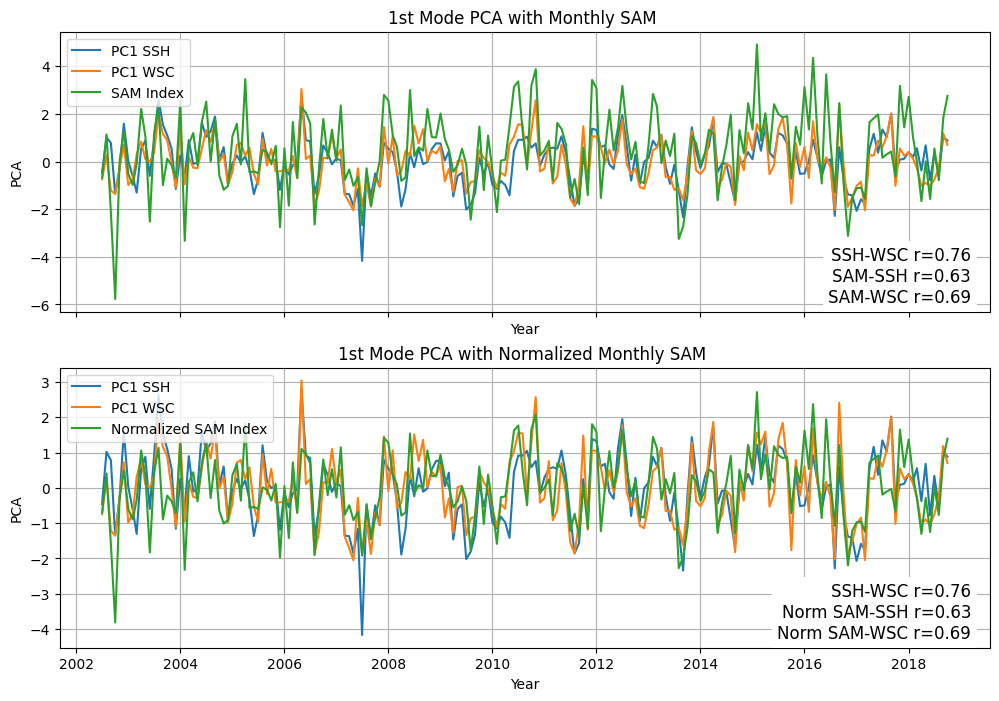

In [34]:
model = xe.cross.MCA(n_modes=22, standardize=True)

model.fit(dot_masked_ds, WSC_eumetsat_ds, dim='time')
comps1, comps2 = model.components()  # Singular vectors (spatial patterns)
scores1, scores2 = model.scores()  # Expansion coefficients (temporal patterns)
s1 = scores1.values;
s2 = scores2.values
c1 = comps1.values;
c2 = comps2.values

#how can you change from using cross.MCA to calling the subplots PCA1, PCA2, PCA3 etc ...
r_pears = [];
p_pears = []
r_spear = [];
p_spear = []
for m in range(1, 5):
    x = scores1.sel(mode=m)
    y = scores2.sel(mode=m)
    r, p = scipy.stats.pearsonr(x, y)
    r_pears.append(np.round(r, 2));
    p_pears.append(np.round(p, 2))
    r, p = scipy.stats.spearmanr(x, y)
    r_spear.append(np.round(r, 2));
    p_spear.append(np.round(p, 2))

# Select only the first mode (PC1)
pc1_scores1 = scores1.sel(mode=1)  # First PC for SSH
pc1_scores2 = scores2.sel(mode=1)  # First PC for WSC

pc1_scores1 = (pc1_scores1 - pc1_scores1.mean()) / pc1_scores1.std()
pc1_scores2 = (pc1_scores2 - pc1_scores2.mean()) / pc1_scores2.std()

# Correlations
r_ssh_wsc, p_ssh_wsc = scipy.stats.pearsonr(pc1_scores1.values, pc1_scores2.values)
r_sam_ssh, p_sam_ssh = scipy.stats.pearsonr(filtered_monthly_sam.values, pc1_scores1.values)
r_sam_wsc, p_sam_wsc = scipy.stats.pearsonr(filtered_monthly_sam.values, pc1_scores2.values)
r_norm_sam_ssh, p_norm_sam_ssh = scipy.stats.pearsonr(normalized_monthly_sam.values, pc1_scores1.values)
r_norm_sam_wsc, p_norm_sam_wsc = scipy.stats.pearsonr(normalized_monthly_sam.values, pc1_scores2.values)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot PCA1
ax1.plot(pc1_scores1.time, pc1_scores1, label="PC1 SSH")
ax1.plot(pc1_scores2.time, pc1_scores2, label="PC1 WSC")
ax1.plot(filtered_monthly_sam.time, filtered_monthly_sam, label="SAM Index")
ax1.set_ylabel("PCA")
ax1.set_xlabel("Year")
ax1.legend(loc="upper left")
ax1.set_title("1st Mode PCA with Monthly SAM ")
ax1.grid(True)

# Add correlation text
correlation_text_1 = f"SSH-WSC r={r_ssh_wsc:.2f}\nSAM-SSH r={r_sam_ssh:.2f}\nSAM-WSC r={r_sam_wsc:.2f}"
ax1.text(0.98, 0.02, correlation_text_1, transform=ax1.transAxes, fontsize=12,
         verticalalignment='bottom', horizontalalignment='right',bbox=dict(facecolor='white', edgecolor='none'))


# Plot normalised SAM
ax2.plot(pc1_scores1.time, pc1_scores1, label="PC1 SSH")
ax2.plot(pc1_scores2.time, pc1_scores2, label="PC1 WSC")
ax2.plot(filtered_monthly_sam.time, normalized_monthly_sam, label="Normalized SAM Index")
ax2.set_ylabel("PCA")
ax2.set_xlabel("Year")
ax2.legend(loc="upper left")
ax2.set_title("1st Mode PCA with Normalized Monthly SAM ")
ax2.grid(True)

# Add correlation text for normalized SAM
correlation_text_2 = f"SSH-WSC r={r_ssh_wsc:.2f}\nNorm SAM-SSH r={r_norm_sam_ssh:.2f}\nNorm SAM-WSC r={r_norm_sam_wsc:.2f}"
ax2.text(0.98, 0.02, correlation_text_2, transform=ax2.transAxes, fontsize=12,
         verticalalignment='bottom', horizontalalignment='right',bbox=dict(facecolor='white', edgecolor='none'))



plt.show()

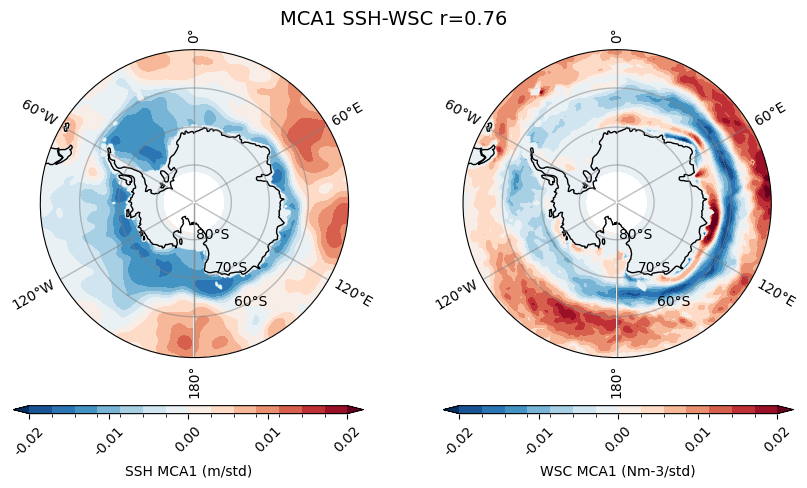

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.path as mpath
from matplotlib.ticker import MaxNLocator
import scipy.stats
import xarray as xr

# Create circle for boundary
theta = np.linspace(0, 2*np.pi, 100)
map_circle = mpath.Path(np.vstack([np.sin(theta), np.cos(theta)]).T * 0.5 + [0.5, 0.5])

# Perform MCA
model = xe.cross.MCA(n_modes=5, standardize=True)  # Adjust modes if needed
model.fit(dot_masked_ds, WSC_eumetsat_ds, dim='time')

# Extract spatial components (Singular Vectors) for SSH & WSC
comps1, comps2 = model.components()

# Select the first mode (Mode 1) for SSH & WSC
mode1_ssh = comps1.sel(mode=1).to_array().squeeze()
mode1_wsc = comps2.sel(mode=1).to_array().squeeze()

pc1_scores1 = scores1.sel(mode=1)  # First PC for SSH
pc1_scores2 = scores2.sel(mode=1)  # First PC for WSC

# Correlations using annual data
r_ssh_wsc, p_ssh_wsc = scipy.stats.pearsonr(pc1_scores1.values, pc1_scores2.values)

# Create figure with two subplots (for SSH and WSC Mode 1)
fig, axes = plt.subplots(1, 2, figsize=(10, 4), subplot_kw={'projection': ccrs.SouthPolarStereo()})

# Define separate color scale limits
vmin_ssh, vmax_ssh = -0.02, 0.02  # SSH scale
vmin_wsc, vmax_wsc = -0.02, 0.02  # WSC scale

# Titles for subplots
#titles = ["SSH (m/std) Mode 1", "WSC (Nm-3/std) Mode 1"]

# Plot SSH (Left subplot)
im1 = mode1_ssh.plot.contourf(ax=axes[0], transform=ccrs.PlateCarree(), cmap="RdBu_r",
                              extend="both", levels=15, add_colorbar=False,
                              vmin=vmin_ssh, vmax=vmax_ssh)
axes[0].set_title(None)
axes[0].set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
axes[0].set_boundary(map_circle, transform=axes[0].transAxes)  # Fix the boundary setting
axes[0].coastlines()

# Add gridlines and latitude/longitude labels for SSH plot
gl1 = axes[0].gridlines(draw_labels=True, xlocs=[-180, -120, -60, 0, 60, 120, 180],
                         ylocs=[-80, -70, -60, -50], linewidth=1, color='gray', alpha=0.5)
gl1.top_labels = True   # Enable top labels
gl1.bottom_labels = True  # Enable bottom labels
gl1.left_labels = True   # Enable left labels
gl1.right_labels = True  # Enable right labels

# Plot WSC (Right subplot)
im2 = mode1_wsc.plot.contourf(ax=axes[1], transform=ccrs.PlateCarree(), cmap="RdBu_r",
                              extend="both", levels=15, add_colorbar=False,
                              vmin=vmin_wsc, vmax=vmax_wsc)
axes[1].set_title(None)
axes[1].set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
axes[1].set_boundary(map_circle, transform=axes[1].transAxes)  # Fix the boundary setting
axes[1].coastlines()

# Add gridlines and latitude/longitude labels for WSC plot
gl2 = axes[1].gridlines(draw_labels=True, xlocs=[-180, -120, -60, 0, 60, 120, 180],
                         ylocs=[-80, -70, -60, -50], linewidth=1, color='gray', alpha=0.5)
gl2.top_labels = True   # Enable top labels
gl2.bottom_labels = True  # Enable bottom labels
gl2.left_labels = True   # Enable left labels
gl2.right_labels = True  # Enable right labels

# Add separate color bars for each subplot
cbar_ax1 = fig.add_axes([0.12, -0.03, 0.35, 0.02])  # [left, bottom, width, height]
cbar1 = fig.colorbar(im1, cax=cbar_ax1, orientation='horizontal', label="SSH MCA1 (m/std)")
cbar1.set_ticks([vmin_ssh, -0.01, 0, 0.01, vmax_ssh])  # Manually set the ticks
cbar1.set_ticklabels([f'{vmin_ssh:.2f}', '-0.01', '0.00', '0.01', f'{vmax_ssh:.2f}'])  # Set exact labels
# Rotate the color bar numbers by 45°
for tick in cbar1.ax.get_xticklabels():
    tick.set_rotation(45)

cbar_ax2 = fig.add_axes([0.55, -0.03, 0.35, 0.02])
cbar2 = fig.colorbar(im2, cax=cbar_ax2, orientation='horizontal', label="WSC MCA1 (Nm-3/std)")
cbar2.set_ticks([vmin_wsc, -0.01, 0, 0.01, vmax_wsc])  # Manually set the ticks
cbar2.set_ticklabels([f'{vmin_wsc:.2f}', '-0.01', '0.00', '0.01', f'{vmax_wsc:.2f}'])  # Set exact labels

# Rotate the color bar numbers by 45°
for tick in cbar2.ax.get_xticklabels():
    tick.set_rotation(45)

# Add a title for the figure
plt.suptitle(f"MCA1 SSH-WSC r={r_ssh_wsc:.2f}", fontsize=14)

# Show the plot
plt.show()


In [36]:
# Calculate the mean over a reference period (for example, along the 'time' dimension)
mean_dot_masked = dot_masked_ds.mean(dim='time')
mean_WSC_eumetsat = WSC_nsidc_ds.mean(dim='time')
mean_tau_eumetsat = tau_nsidc_ds.mean(dim='time')
mean_sidc_eumetsat = sidc_nsidc_ds.mean(dim='time')
mean_OSC_eumetsat = OSC_nsidc_ds.mean(dim='time')

# Now calculate anomalies by subtracting the mean from the original dataset
dot_masked_anomalies = dot_masked_ds - mean_dot_masked
WSC_eumetsat_anomalies = WSC_eumetsat_ds - mean_WSC_eumetsat
tau_eumetsat_anomalies = tau_eumetsat_ds - mean_tau_eumetsat
sidc_eumetsat_anomalies = sidc_eumetsat_ds - mean_sidc_eumetsat
OSC_eumetsat_anomalies = OSC_eumetsat_ds - mean_OSC_eumetsat


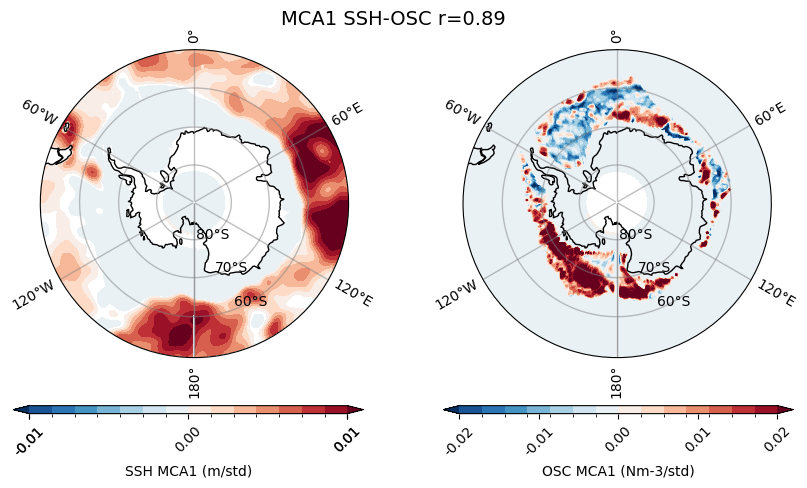

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.path as mpath
from matplotlib.ticker import MaxNLocator
import scipy.stats
import xarray as xr

# Create circle for boundary
theta = np.linspace(0, 2*np.pi, 100)
map_circle = mpath.Path(np.vstack([np.sin(theta), np.cos(theta)]).T * 0.5 + [0.5, 0.5])

# Perform MCA
model = xe.cross.MCA(n_modes=5, standardize=True)  # Adjust modes if needed
model.fit(dot_masked_ds, OSC_eumetsat_ds, dim='time')

# Extract spatial components (Singular Vectors) for SSH & WSC
comps1, comps2 = model.components()

# Select the first mode (Mode 1) for SSH & WSC
mode1_ssh = comps1.sel(mode=1).to_array().squeeze()
mode1_wsc = comps2.sel(mode=1).to_array().squeeze()

pc1_scores1 = scores1.sel(mode=1)  # First PC for SSH
pc1_scores2 = scores2.sel(mode=1)  # First PC for WSC

# Correlations using annual data
r_ssh_wsc, p_ssh_wsc = scipy.stats.pearsonr(pc1_scores1.values, pc1_scores2.values)

# Create figure with two subplots (for SSH and WSC Mode 1)
fig, axes = plt.subplots(1, 2, figsize=(10, 4), subplot_kw={'projection': ccrs.SouthPolarStereo()})

# Define separate color scale limits
vmin_ssh, vmax_ssh = -0.01, 0.01  # SSH scale
vmin_wsc, vmax_wsc = -0.02, 0.02  # WSC scale

# Titles for subplots
#titles = ["SSH (m/std) Mode 1", "WSC (Nm-3/std) Mode 1"]

# Plot SSH (Left subplot)
im1 = mode1_ssh.plot.contourf(ax=axes[0], transform=ccrs.PlateCarree(), cmap="RdBu_r",
                              extend="both", levels=15, add_colorbar=False,
                              vmin=vmin_ssh, vmax=vmax_ssh)
axes[0].set_title(None)
axes[0].set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
axes[0].set_boundary(map_circle, transform=axes[0].transAxes)  # Fix the boundary setting
axes[0].coastlines()

# Add gridlines and latitude/longitude labels for SSH plot
gl1 = axes[0].gridlines(draw_labels=True, xlocs=[-180, -120, -60, 0, 60, 120, 180],
                         ylocs=[-80, -70, -60, -50], linewidth=1, color='gray', alpha=0.5)
gl1.top_labels = True   # Enable top labels
gl1.bottom_labels = True  # Enable bottom labels
gl1.left_labels = True   # Enable left labels
gl1.right_labels = True  # Enable right labels

# Plot WSC (Right subplot)
im2 = mode1_wsc.plot.contourf(ax=axes[1], transform=ccrs.PlateCarree(), cmap="RdBu_r",
                              extend="both", levels=15, add_colorbar=False,
                              vmin=vmin_wsc, vmax=vmax_wsc)
axes[1].set_title(None)
axes[1].set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
axes[1].set_boundary(map_circle, transform=axes[1].transAxes)  # Fix the boundary setting
axes[1].coastlines()

# Add gridlines and latitude/longitude labels for WSC plot
gl2 = axes[1].gridlines(draw_labels=True, xlocs=[-180, -120, -60, 0, 60, 120, 180],
                         ylocs=[-80, -70, -60, -50], linewidth=1, color='gray', alpha=0.5)
gl2.top_labels = True   # Enable top labels
gl2.bottom_labels = True  # Enable bottom labels
gl2.left_labels = True   # Enable left labels
gl2.right_labels = True  # Enable right labels

# Add separate color bars for each subplot
cbar_ax1 = fig.add_axes([0.12, -0.03, 0.35, 0.02])  # [left, bottom, width, height]
cbar1 = fig.colorbar(im1, cax=cbar_ax1, orientation='horizontal', label="SSH MCA1 (m/std)")
cbar1.set_ticks([vmin_ssh, -0.01, 0, 0.01, vmax_ssh])  # Manually set the ticks
cbar1.set_ticklabels([f'{vmin_ssh:.2f}', '-0.01', '0.00', '0.01', f'{vmax_ssh:.2f}'])  # Set exact labels
# Rotate the color bar numbers by 45°
for tick in cbar1.ax.get_xticklabels():
    tick.set_rotation(45)

cbar_ax2 = fig.add_axes([0.55, -0.03, 0.35, 0.02])
cbar2 = fig.colorbar(im2, cax=cbar_ax2, orientation='horizontal', label="OSC MCA1 (Nm-3/std)")
cbar2.set_ticks([vmin_wsc, -0.01, 0, 0.01, vmax_wsc])  # Manually set the ticks
cbar2.set_ticklabels([f'{vmin_wsc:.2f}', '-0.01', '0.00', '0.01', f'{vmax_wsc:.2f}'])  # Set exact labels

# Rotate the color bar numbers by 45°
for tick in cbar2.ax.get_xticklabels():
    tick.set_rotation(45)

# Add a title for the figure
plt.suptitle(f"MCA1 SSH-OSC r={r_ssh_wsc:.2f}", fontsize=14)

# Show the plot
plt.show()


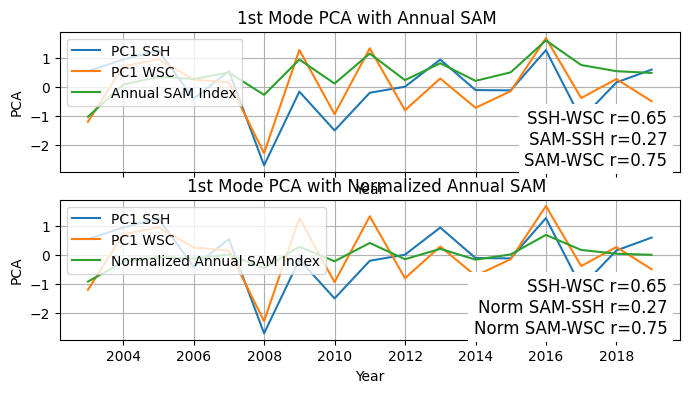

In [38]:
# Compute annual means for PC1 scores and SAM index
pc1_scores1_ann = scores1.sel(mode=1).resample(time='Y').mean()  # First PC for SSH
pc1_scores2_ann = scores2.sel(mode=1).resample(time='Y').mean()  # First PC for WSC
filtered_annual_sam = filtered_monthly_sam.resample(time='Y').mean()
normalized_annual_sam = normalized_monthly_sam.resample(time='Y').mean()

# Normalize PC1 scores
pc1_scores1_ann = (pc1_scores1_ann - pc1_scores1_ann.mean()) / pc1_scores1_ann.std()
pc1_scores2_ann = (pc1_scores2_ann - pc1_scores2_ann.mean()) / pc1_scores2_ann.std()

# Correlations using annual data
r_ssh_wsc, p_ssh_wsc = scipy.stats.pearsonr(pc1_scores1_ann.values, pc1_scores2_ann.values)
r_sam_ssh, p_sam_ssh = scipy.stats.pearsonr(filtered_annual_sam.values, pc1_scores1_ann.values)
r_sam_wsc, p_sam_wsc = scipy.stats.pearsonr(filtered_annual_sam.values, pc1_scores2_ann.values)
r_norm_sam_ssh, p_norm_sam_ssh = scipy.stats.pearsonr(normalized_annual_sam.values, pc1_scores1_ann.values)
r_norm_sam_wsc, p_norm_sam_wsc = scipy.stats.pearsonr(normalized_annual_sam.values, pc1_scores2_ann.values)

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 4), sharex=True)

# Plot PCA1 with annual SAM
ax1.plot(pc1_scores1_ann.time, pc1_scores1_ann, label="PC1 SSH")
ax1.plot(pc1_scores2_ann.time, pc1_scores2_ann, label="PC1 WSC")
ax1.plot(filtered_annual_sam.time, filtered_annual_sam, label="Annual SAM Index")
ax1.set_ylabel("PCA")
ax1.set_xlabel("Year")
ax1.legend(loc="upper left")
ax1.set_title("1st Mode PCA with Annual SAM ")
ax1.grid(True)

# Add correlation text
correlation_text_1 = f"SSH-WSC r={r_ssh_wsc:.2f}\nSAM-SSH r={r_sam_ssh:.2f}\nSAM-WSC r={r_sam_wsc:.2f}"
ax1.text(0.98, 0.02, correlation_text_1, transform=ax1.transAxes, fontsize=12,
         verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='white', edgecolor='none'))

# Plot PCA1 with normalized annual SAM
ax2.plot(pc1_scores1_ann.time, pc1_scores1_ann, label="PC1 SSH")
ax2.plot(pc1_scores2_ann.time, pc1_scores2_ann, label="PC1 WSC")
ax2.plot(normalized_annual_sam.time, normalized_annual_sam, label="Normalized Annual SAM Index")
ax2.set_ylabel("PCA")
ax2.set_xlabel("Year")
ax2.legend(loc="upper left")
ax2.set_title("1st Mode PCA with Normalized Annual SAM ")
ax2.grid(True)

# Add correlation text for normalized SAM
correlation_text_2 = f"SSH-WSC r={r_ssh_wsc:.2f}\nNorm SAM-SSH r={r_norm_sam_ssh:.2f}\nNorm SAM-WSC r={r_norm_sam_wsc:.2f}"
ax2.text(0.98, 0.02, correlation_text_2, transform=ax2.transAxes, fontsize=12,
         verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='white', edgecolor='none'))

plt.show()


In [39]:

# Define seasons based on months
seasons = {
    'SPR': [9, 10, 11],  # SON (Spring in SH)
    'SUM': [12, 1, 2],   # DJF (Summer in SH)
    'AUT': [3, 4, 5],    # MAM (Autumn in SH)
    'WIN': [6, 7, 8]     # JJA (Winter in SH)
}

def seasonal_avg(ds):
    """Compute seasonal averages for a given dataset."""
    seasonal_data = {}
    for season, months in seasons.items():
        season_ds = ds.where(ds['time'].dt.month.isin(months), drop=True)
        seasonal_mean = season_ds.groupby("time.year").mean(dim="time")
        seasonal_data[season] = seasonal_mean
    return seasonal_data

# Compute seasonal means directly
ssh_seasonal = seasonal_avg(dot_masked_ds)
wsc_seasonal = seasonal_avg(WSC_eumetsat_ds)

# Rename for MCA analysis
spr_ann = ssh_seasonal['SPR'], wsc_seasonal['SPR']
sum_ann = ssh_seasonal['SUM'], wsc_seasonal['SUM']
aut_ann = ssh_seasonal['AUT'], wsc_seasonal['AUT']
win_ann = ssh_seasonal['WIN'], wsc_seasonal['WIN']


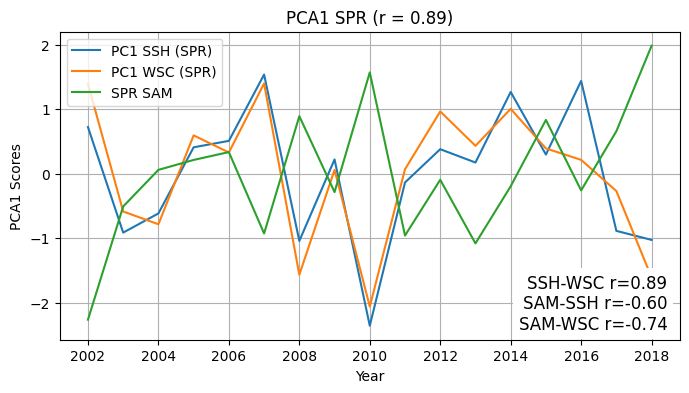

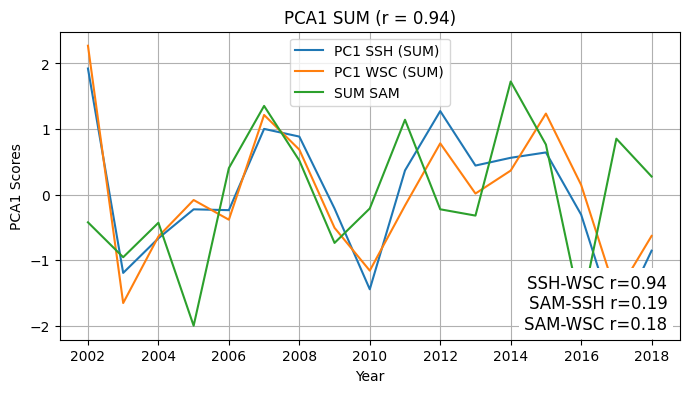

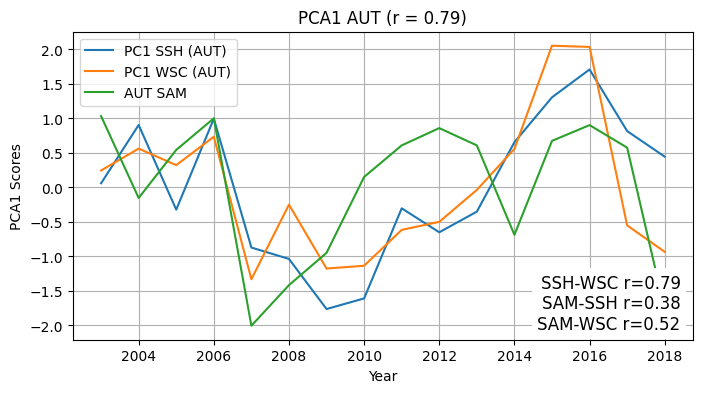

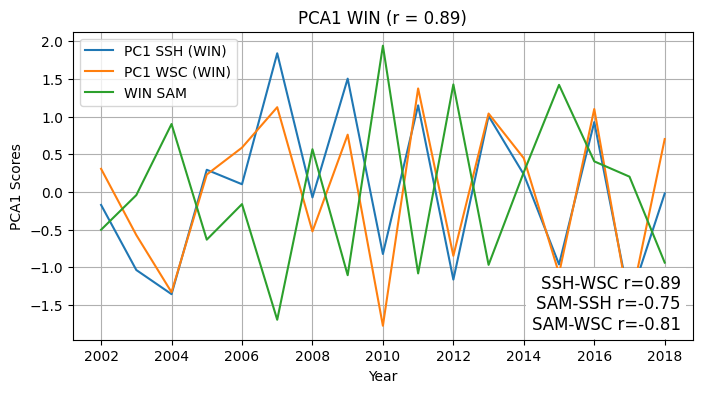

In [40]:
import scipy.stats
import matplotlib.pyplot as plt

seasons = ['SPR', 'SUM', 'AUT', 'WIN']

for season in seasons:
    # Extract seasonal data
    ssh_season = ssh_seasonal[season]
    wsc_season = wsc_seasonal[season]
    sam_season = normalized_sams[season]  # Assuming `normalized_sams` has seasonal SAM index

    # Fit the MCA model for the current season
    model = xe.cross.MCA(n_modes=4, standardize=True)
    model.fit(ssh_season, wsc_season, dim='year')
    comps1, comps2 = model.components()
    scores1, scores2 = model.scores()

    # Extract PCA1 scores for SSH and WSC
    pc1_scores1 = scores1.sel(mode=1)
    pc1_scores2 = scores2.sel(mode=1)

    # Normalize PCA1 scores
    pc1_scores1 = (pc1_scores1 - pc1_scores1.mean()) / pc1_scores1.std()
    pc1_scores2 = (pc1_scores2 - pc1_scores2.mean()) / pc1_scores2.std()

    # Compute Pearson Correlations
    r_ssh_wsc, p_ssh_wsc = scipy.stats.pearsonr(pc1_scores1.values, pc1_scores2.values)
    r_sam_ssh, p_sam_ssh = scipy.stats.pearsonr(sam_season.values, pc1_scores1.values)
    r_sam_wsc, p_sam_wsc = scipy.stats.pearsonr(sam_season.values, pc1_scores2.values)

    # Compute Spearman Correlations
    r_spear_ssh_wsc, _ = scipy.stats.spearmanr(pc1_scores1.values, pc1_scores2.values)
    r_spear_sam_ssh, _ = scipy.stats.spearmanr(sam_season.values, pc1_scores1.values)
    r_spear_sam_wsc, _ = scipy.stats.spearmanr(sam_season.values, pc1_scores2.values)

    # Plot results
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(ssh_season.year, pc1_scores1, label=f'PC1 SSH ({season})')
    ax.plot(wsc_season.year, pc1_scores2, label=f'PC1 WSC ({season})')
    ax.plot(sam_season.year, sam_season, label=f'{season} SAM')

    # Add title, labels, and grid
    ax.set_title(f'PCA1 {season} (r = {r_ssh_wsc:.2f})')
    ax.set_xlabel('Year')
    ax.set_ylabel('PCA1 Scores')
    ax.legend()
    ax.grid(True)

    # Add correlation text
    correlation_text = (f"SSH-WSC r={r_ssh_wsc:.2f}\n"
                        f"SAM-SSH r={r_sam_ssh:.2f}\n"
                        f"SAM-WSC r={r_sam_wsc:.2f}")
    ax.text(0.98, 0.02, correlation_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='white', edgecolor='none'))

    plt.show()


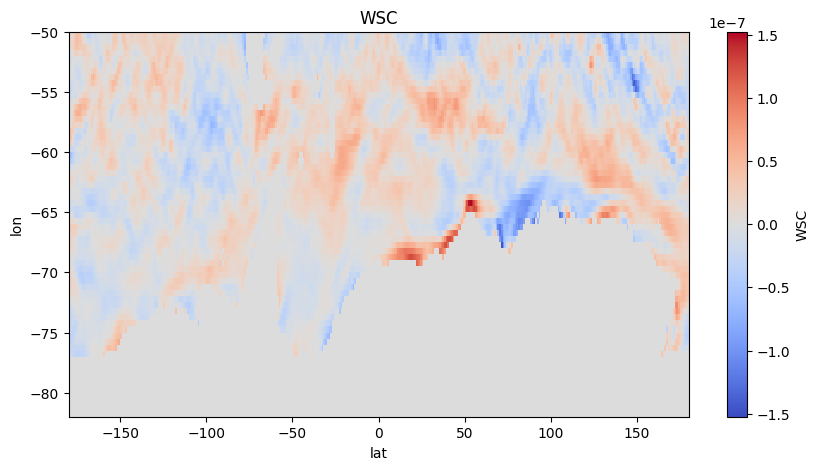

In [41]:
# Select one year of data (e.g., 2010)
# variable = tau_eumetsat_ds['tau_x_wsc']
variable = WSC_eumetsat_ds['WSC']
variable_name = variable.name
one_year_data = (variable.sel(time=slice("2018-01-01", "2018-12-31")))

# Plot the mean over time to visualize annual SIDC distribution
plt.figure(figsize=(10, 5))
one_year_data.mean(dim="time").plot(cmap="coolwarm")  # Adjust colormap if needed
plt.title(f"{variable_name}")

plt.show()


In [42]:
print(variable.time.min())
print(variable.time.max())

<xarray.DataArray 'time' ()> Size: 8B
array('2002-07-01T00:00:00.000000000', dtype='datetime64[ns]')
<xarray.DataArray 'time' ()> Size: 8B
array('2018-10-01T00:00:00.000000000', dtype='datetime64[ns]')


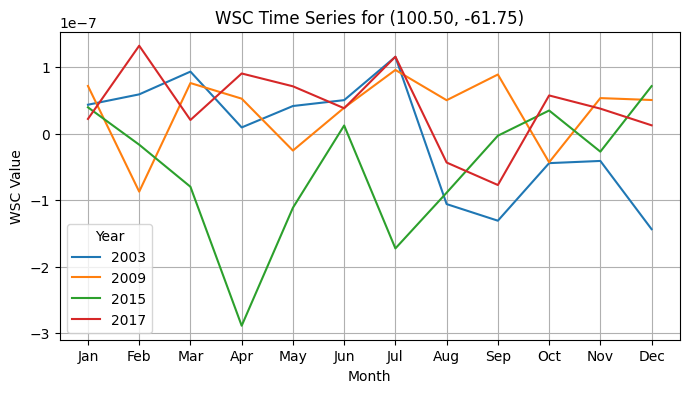

In [43]:
import xarray as xr
import matplotlib.pyplot as plt

# Define the approximate location
latitude = 100.0   # Example latitude
longitude = -62.0 # Example longitude

# Find the nearest available lat/lon
nearest_point = variable.sel(lat=latitude, lon=longitude, method="nearest")

# Now, slice the time range for one year (e.g., 2010)
one_year_data_1 = nearest_point.sel(time=slice("2003-01-01", "2003-12-31"))
one_year_data_2 = nearest_point.sel(time=slice("2009-01-01", "2009-12-31"))
one_year_data_3 = nearest_point.sel(time=slice("2015-01-01", "2015-12-31"))
one_year_data_4 = nearest_point.sel(time=slice("2017-01-01", "2017-12-31"))


one_year_data_1['time'] = one_year_data_1.time.dt.month
one_year_data_2['time'] = one_year_data_2.time.dt.month
one_year_data_3['time'] = one_year_data_3.time.dt.month
one_year_data_4['time'] = one_year_data_4.time.dt.month

# Extract the exact coordinates used
nearest_lat = nearest_point.lat.values
nearest_lon = nearest_point.lon.values

# Plot the time series
plt.figure(figsize=(8, 4))
plt.plot(one_year_data_1.time, one_year_data_1, label="2003")
plt.plot(one_year_data_2.time, one_year_data_2, label="2009")
plt.plot(one_year_data_3.time, one_year_data_3, label="2015")
plt.plot(one_year_data_4.time, one_year_data_4, label="2017")

# Format x-axis with month names
plt.xticks(ticks=range(1, 13), labels=pd.date_range("2000-01-01", periods=12, freq="M").strftime("%b"))

plt.xlabel("Month")
plt.ylabel("WSC Value")
plt.title(f"WSC Time Series for ({nearest_lat:.2f}, {nearest_lon:.2f})")
plt.legend(title="Year")
plt.grid()
plt.show()


